# Stochastic volatility
This Notebook demos how to construct a stochastic volatility model and fit it to data. We will use a version of the precision model of G. Chacko and L. M. Viceira. `Dynamic consumption and portfolio choice with stochastic volatility in incomplete markets` given by
\begin{cases}
Y_t = \mu + \beta e^{-2 V_t} + e^{-V_t} W_t, \\
\mathrm{d}V_t = \kappa \left (\gamma - V_t \right ) \mathrm{d}t + \sigma \mathrm{d}B_t, \\
\end{cases}
where $\mu, \beta, \gamma \in \mathbb{R}$, and $\kappa, \sigma \in \mathbb{R}_+$.$\{B_t\}$ is a one-dimensional Wiener processes, wheras $\{W_t\}$ is assumed to follow a Student's t distribution with $\nu$ degrees of freedom. 

We begin with importing the necessary libraries for defining the model.

In [1]:
from pyfilter.timeseries import StateSpaceModel, OrnsteinUhlenbeck, AffineObservations, Parameter

Next, we define the governing dynamics

In [2]:
import torch


def go(vol, level, beta):
    return level + beta * (-2 * vol).exp()


def fo(vol, level, beta):
    return (-vol).exp()

Next, we shall define our model. In order to do so, we must specify priors for the different parameters. Given their support, we assume that
\begin{cases}
    \gamma \sim \mathcal{N}(0, 1), \\
    \mu, \beta \sim \mathcal{N}(0, 0.5), \\
    \nu \sim \mathcal{E}(0.1), \\
    \kappa \sim \mathcal{E}(10), \\
    \sigma \sim \mathcal{E}(5). \\
\end{cases}
To do this, we need to import the necessary distributions.

In [3]:
from torch.distributions import Exponential, Normal, StudentT

Next, we define the model in terms of code and get

In [4]:
logvol = OrnsteinUhlenbeck(Exponential(10.), Normal(0., 1.), Exponential(5))
nu = Parameter(Exponential(0.1))
obs = AffineObservations((go, fo), (Normal(0., 0.5), Normal(0., 0.5)), StudentT(nu))

stockmodel = StateSpaceModel(logvol, obs)

And that defines the model. Next, we need a dataset to train on. We're just going to pick the S&P500, and for the fun of it - let's consider the entire series.

In [5]:
import numpy as np
import pandas as pd
from yfinance import Ticker

spx = Ticker('^GSPC')
y = np.log(1 + spx.history(period='max').Close.pct_change().iloc[1:]) * 100

We plot the data to get an idea of its volatility

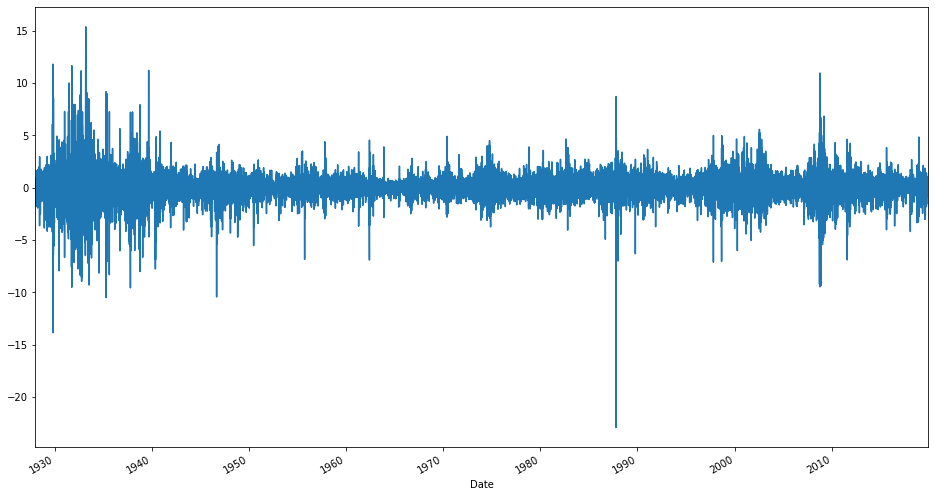

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
y.plot(ax=ax)

In order to fit the model to the given data, we need an algorithm. We shall use the NESSMC2 algorithm by Crisan and Miguez. Furthermore, since we are using particle filters, we need to decide on which proposal to use - should we go with the Bootstrap or something more advanced? For this example, we will use the bootstrap as the problem's so low dimensional. Importing the relevant classes, we get

In [7]:
from pyfilter.algorithms import NESSMC2
from pyfilter.filters import SISR

Let's now fit the model to the data, but first moving it to the GPU (GTX 1070)

In [8]:
from pyfilter.resampling import multinomial
from pyfilter.algorithms.kernels import AdaptiveKernel

predictions = 10
training = torch.from_numpy(y.values[:-predictions]).float().cuda()

algs = list()
for i in range(2):
    kernel = AdaptiveKernel(record_stats=True)
    filt = SISR(stockmodel.copy(), 250, resampling=multinomial, ess=1.)
    alg = NESSMC2(filt, 2000, switch=2000, smc2_th=0.2, kernel=kernel).to_('cuda:0').initialize()
    
    alg.fit(training)
    
    algs.append(alg)

NESS: 100%|██████████████████████████████████████████████████████████████████████| 23082/23082 [23:28<00:00, 21.36it/s]


Next, we plot the posterior distributions. The first three correspond to the reversion, mean and standard deviation of the latent process. The last three ones correspond to the mean, exposure to variance and dof of the Student's t distribution.

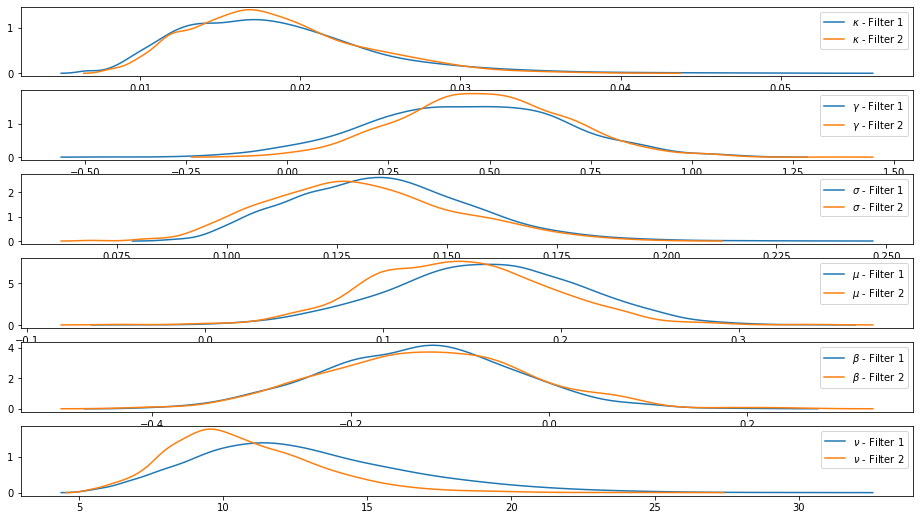

In [20]:
from pyfilter.utils import normalize
import pandas as pd

fig, ax = plt.subplots(len(alg.filter.ssm.theta_dists), figsize=(16, 9))

syms = '\\kappa, \\gamma, \\sigma, \\mu, \\beta, \\nu'.split(',')

for r, alg in enumerate(algs):
    if not hasattr(alg, '_w_rec'):
        w = normalize(alg._ness._w_rec)
    else:
        w = normalize(alg._w_rec)

    for i, param in enumerate(alg.filter.ssm.theta_dists):    
        xrange, xvals = param.get_plottable(weights=w)

        mean = (w * param).sum()
        std = (w * (param - mean) ** 2).sum().sqrt()

        ax[i].plot(xrange, xvals, label='${}$ - Filter {:d}'.format(syms[i], r+1))

        ax[i].legend()

Let's plot a crude estimate of the underlying volatility. I say crude here because we uniformly weight the trajectories.

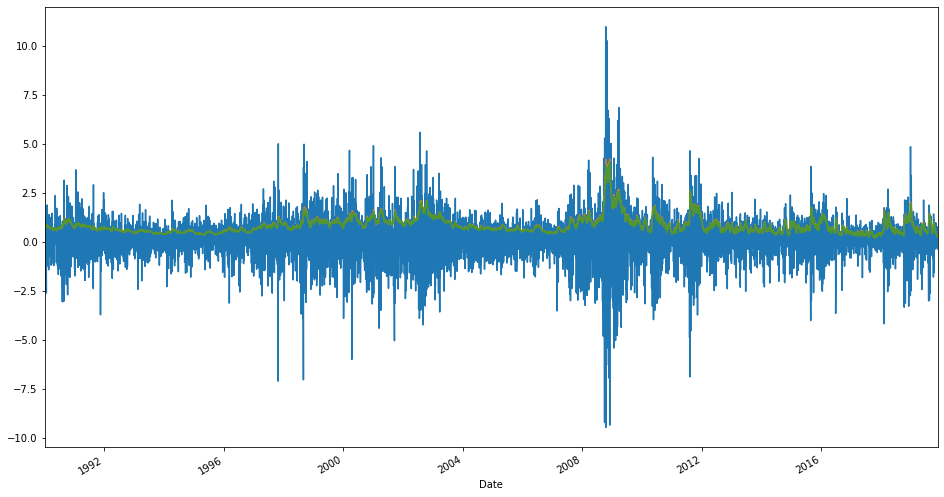

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
trunc = y.loc['1990-01-01':].iloc[:-predictions]
trunc.plot(ax=ax)

indx = y.index[:training.shape[0]]
for alg in algs:
    asdf = pd.DataFrame((-alg.filter.filtermeans).exp().cpu().numpy(), index=indx).mean(1)    
    asdf.loc[trunc.index].plot(alpha=0.75, ax=ax)

A plot over the ESS.

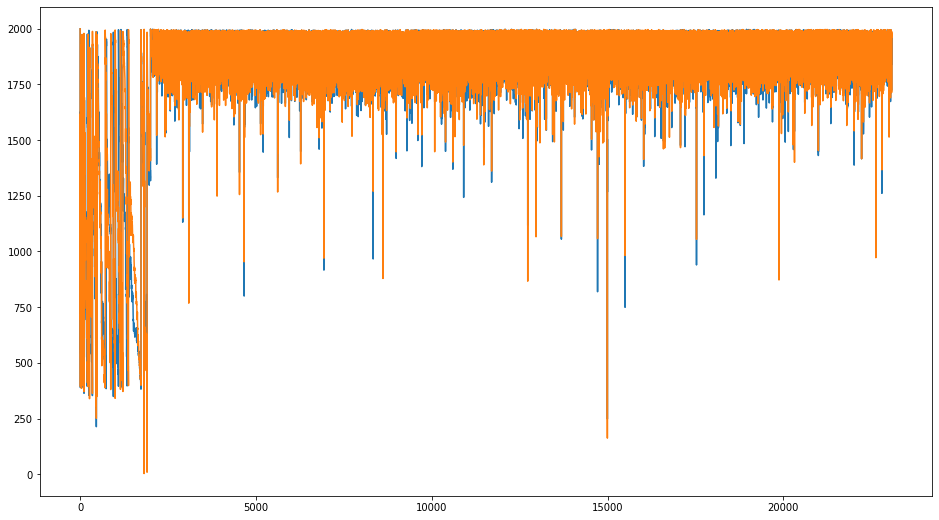

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
for alg in algs:
    ax.plot(alg.logged_ess.cpu().numpy())

Let's get an estimate of the return distribution 10 steps (days) into the future.

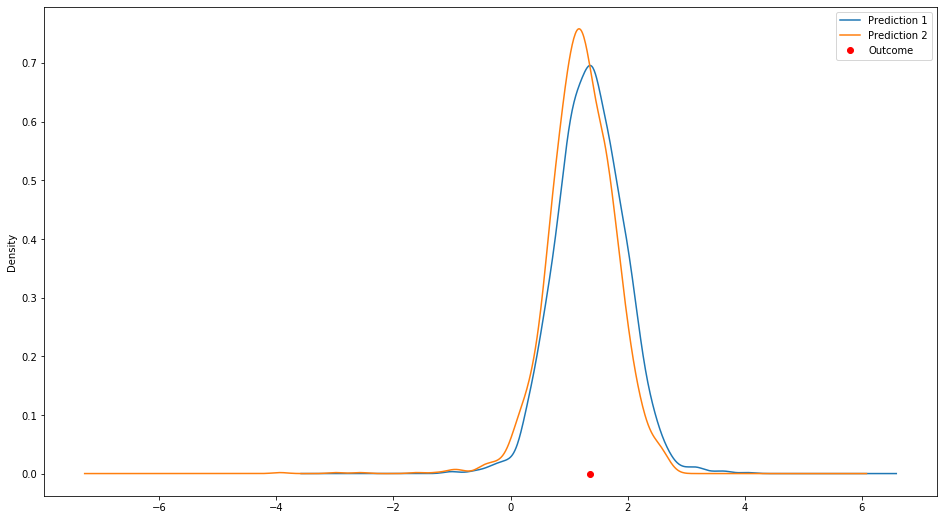

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))

for i, alg in enumerate(algs):
    _, yt = alg.predict(predictions, aggregate=False)    
    
    final = pd.Series(yt.sum(0).median(dim=-1)[0].cpu().numpy())    
    final = final.sort_values()[int(0.025 * final.size):int(0.975 * final.size)]

    final.plot.kde(ax=ax, label='Prediction {:d}'.format(i + 1))

ax.plot(y.iloc[-predictions:].sum(), 0, 'ro', label='Outcome')
ax.legend()

Let's also check how the parameters have varied over time. It's the same order as for the posterior plots.

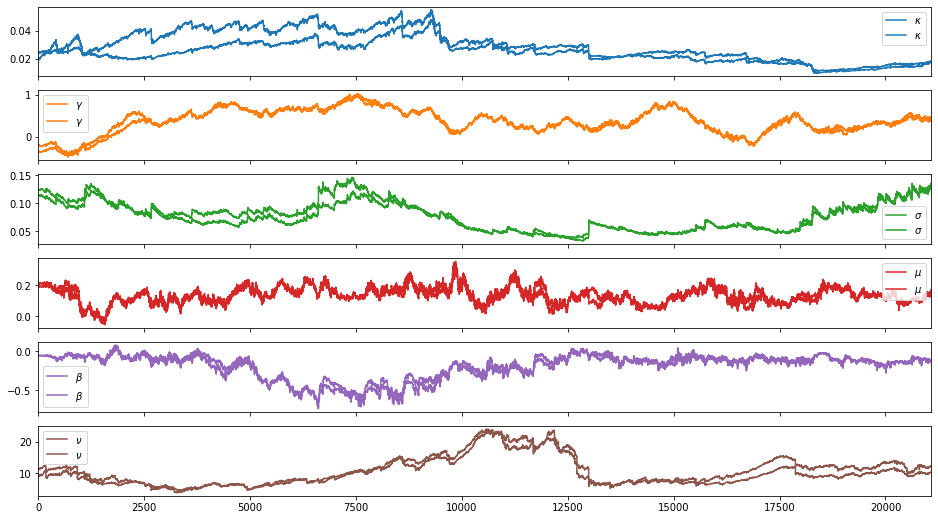

In [24]:
fig, ax = plt.subplots(len(algs[0].filter.ssm.theta_dists), figsize=(16, 9), sharex=True)

cols = ['${}$'.format(s) for s in syms]
for alg in algs:
    df = pd.DataFrame(alg._ness._kernel.get_as_numpy()['mean'], columns=cols)
    
    for c, p in zip(df, alg.filter.ssm.theta_dists):
        df[c] = p.bijection(torch.from_numpy(df[c].values)).numpy()
        
    df.plot(ax=ax, subplots=True)